## Week 11 Homework (9)

### Q1: copulas

1. ~~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~~
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it 
4. Describe how to use this to create arbitrary multivariate GLM regressions

3. A copula is a method for allowing you to express the joint multivariate distribution of univariate marginals by using a multivariate distribution like the Multivariate normal and specifiying the dependency structure between the random variables. Specifically, the marginal distributions are transformed using their (CDFs) to the standard normal scale via the inverse normal CDF from which we learn the dependency structure. 

> In the code, both versions implement this. They start by defining the marginal distributions for the data. Then they transform each observation into a uniform scale using the CDF's and then they associated standard normal value. They do this using the inverse normal CDF. The primary difference is in the coding style and organization. 

4. Copulas involve building a separate regression model for each outcome and then putting them all together. Using the inverse cdf of each outcome we turn the $X\beta$ into ranging over 0 to 1. This is all then converted into a standard normal scale which we then combine all the outcomes together with to learn their dependency structure.

### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



/opt/conda/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p_slab, beta_spike, beta_slab, packed_L]
>BinaryGibbsMetropolis: [z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3062 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]  0.010  0.010  -0.002    0.023      0.007    0.001       3.0   
betas[0, 1] -0.000  0.001  -0.002    0.001      0.000    0.000     168.0   
betas[1, 0]  0.805  0.808  -0.003    1.725      0.567    0.002       3.0   
betas[1, 1]  0.097  0.189  -0.003    0.530      0.072    0.051      11.0   
betas[2, 0]  0.000  0.000   0.000    0.000      0.000    0.000       8.0   
betas[2, 1]  0.000  0.000   0.000    0.000      0.000    0.000    1626.0   
z[0, 0]      0.500  0.500   0.000    1.000      0.352    0.000       2.0   
z[0, 1]      0.254  0.436   0.000    1.000      0.185    0.104       6.0   
z[1, 0]      0.742  0.437   0.000    1.000      0.195    0.108       5.0   
z[1, 1]      0.514  0.500   0.000    1.000      0.028    0.001     324.0   
z[2, 0]      0.505  0.500   0.000    1.000      0.349    0.004       2.0   
z[2, 1]      0.598  0.490   0.000    1.000      0.306    0.062       3.0   
p_slab      

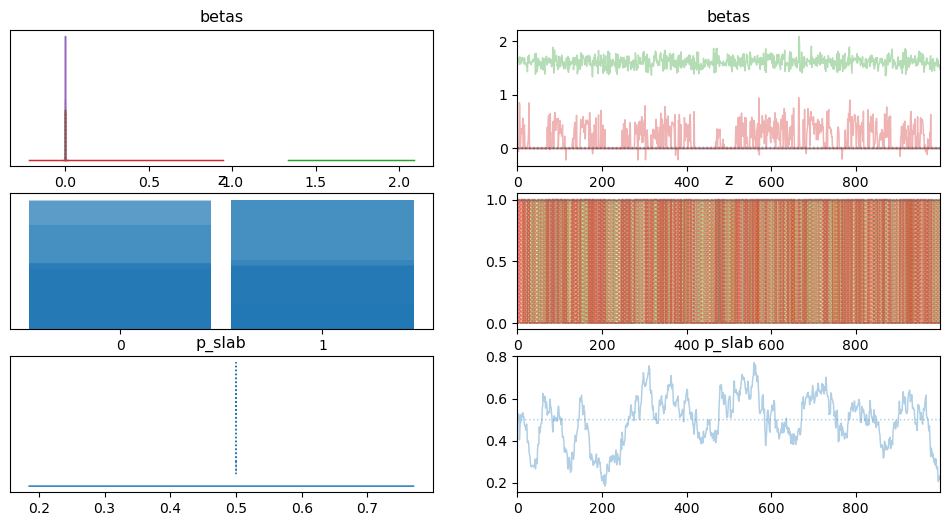

In [4]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import aesara.tensor as at

# -----------------------------------------------------------
# 1. Load and Prepare Data
# -----------------------------------------------------------
df = pd.read_csv("Life Expectancy Data.csv")
# Drop missing rows in columns of interest
df = df.dropna(subset=[
    "percentage expenditure", " BMI ", "Schooling", "Population",
    "Life expectancy ", "Adult Mortality", "infant deaths"
])

# Define predictor and outcome columns
predictors = ["percentage expenditure", " BMI ", "Population"]
outcomes   = ["Life expectancy ", "infant deaths"]

# Convert to NumPy arrays
X_full = df[predictors].values
y_full = df[outcomes].values

# For demonstration, take a smaller subset
n = 50
df_trunc = df.sample(n=n, random_state=42)
X_data = df_trunc[predictors].values
y_data = df_trunc[outcomes].values

# Dimensions
n_rows, p = X_data.shape      # number of observations, number of predictors
m = y_data.shape[1]           # number of outcome dimensions

# -----------------------------------------------------------
# 2. Define the Spike-and-Slab Model
# -----------------------------------------------------------
with pm.Model() as spike_slab_model:
    # (A) Probability that each beta_{j,k} is in the slab vs. spike
    p_slab = pm.Beta("p_slab", alpha=2, beta=2)
    
    # (B) Discrete indicators z_{j,k}: 0 => spike, 1 => slab
    z = pm.Bernoulli("z", p_slab, shape=(p, m))
    
    # (C) Spike and Slab distributions
    #     For simplicity, fix their standard deviations.
    sigma_spike = 0.001
    sigma_slab  = 1.0
    
    # For each (j,k), we *could* do a mixture distribution, but an easier approach:
    # define two sets of latent coefficients, then pick between them using z.
    beta_spike = pm.Normal(
        "beta_spike",
        mu=0.0,
        sigma=sigma_spike,
        shape=(p, m)
    )
    beta_slab = pm.Normal(
        "beta_slab",
        mu=0.0,
        sigma=sigma_slab,
        shape=(p, m)
    )
    
    # (D) Combine them in a deterministic way:
    #     beta_{j,k} = z_{j,k}*beta_slab_{j,k} + (1 - z_{j,k})*beta_spike_{j,k}
    betas = pm.Deterministic("betas", z * beta_slab + (1 - z) * beta_spike)
    
    # (E) LKJ Cholesky prior for covariance among outcome dimensions
    packed_L = pm.LKJCholeskyCov(
        "packed_L",
        n=m,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0, shape=m),
        compute_corr=False
    )
    L = pm.expand_packed_triangular(m, packed_L)
    
    # (F) Mean structure: mu_{i,k} = sum_j X[i,j]*betas_{j,k}
    mu = pm.math.dot(X_data, betas)
    
    # (G) Multivariate Normal likelihood
    y_obs = pm.MvNormal(
        "y_obs",
        mu=mu,
        chol=L,
        observed=y_data
    )
    
    # (H) Sampling:
    #     We typically sample continuous parameters with NUTS/HMC,
    #     and discrete indicators with a discrete step method (e.g. Metropolis).
    step = [
        pm.NUTS(vars=[beta_spike, beta_slab, packed_L]),  # continuous parameters
        pm.BinaryMetropolis(vars=[z])                     # discrete indicators
    ]
    
    idata_ss = pm.sample(chains=2, random_seed=42)

# -----------------------------------------------------------
# 3. Summaries and Diagnostics
# -----------------------------------------------------------
print(az.summary(idata_ss, var_names=["betas", "z", "p_slab"]))
az.plot_trace(idata_ss, var_names=["betas", "z", "p_slab"]);


### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# -----------------------------------------------------------
# 1. Load and Prepare Data
# -----------------------------------------------------------
df = pd.read_csv("Life Expectancy Data.csv")
# Drop missing rows in columns of interest
df = df.dropna(subset=[
    "percentage expenditure", " BMI ", "Schooling", "Population",
    "Life expectancy ", "Adult Mortality", "infant deaths"
])

# Define predictor and outcome columns
predictors = ["percentage expenditure", " BMI ", "Population"]
outcomes   = ["Life expectancy ", "infant deaths"]

# Convert to NumPy arrays
X_full = df[predictors].values
y_full = df[outcomes].values

# The full dataset size
n_full = X_full.shape[0]

# For demonstration, we use a smaller sample
n = 50
df_trunc = df.sample(n=n, random_state=42)
X_data = df_trunc[predictors].values
y_data = df_trunc[outcomes].values

# Get shapes
n_rows, p = X_data.shape
m = y_data.shape[1]  # number of outcome dimensions

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [packed_L, tau, lambdas, betas]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1957 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


                mean        sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]    0.014     0.015  -0.003    0.030      0.010    0.000       3.0   
betas[0, 1]    0.005     0.007  -0.007    0.012      0.005    0.000       3.0   
betas[1, 0]    0.396     1.249  -0.851    1.756      0.879    0.001       3.0   
betas[1, 1]   -0.245     0.675  -0.904    0.655      0.466    0.005       3.0   
betas[2, 0]    0.000     0.000   0.000    0.000      0.000    0.000       3.0   
betas[2, 1]    0.000     0.000   0.000    0.000      0.000    0.000      23.0   
tau            0.467     0.361   0.002    0.761      0.214    0.034       3.0   
lambdas[0]     0.386     0.517   0.000    0.748      0.019    0.075       9.0   
lambdas[1]   184.167  1399.193   0.391  265.860     72.664  384.883       3.0   
lambdas[2]     0.706     0.705   0.000    1.411      0.497    0.000       3.0   

             ess_tail  r_hat  
betas[0, 0]      78.0   1.83  
betas[0, 1]      28.0   1.93  
betas[1, 0]    

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'lambdas'}>,
        <Axes: title={'center': 'lambdas'}>]], dtype=object)

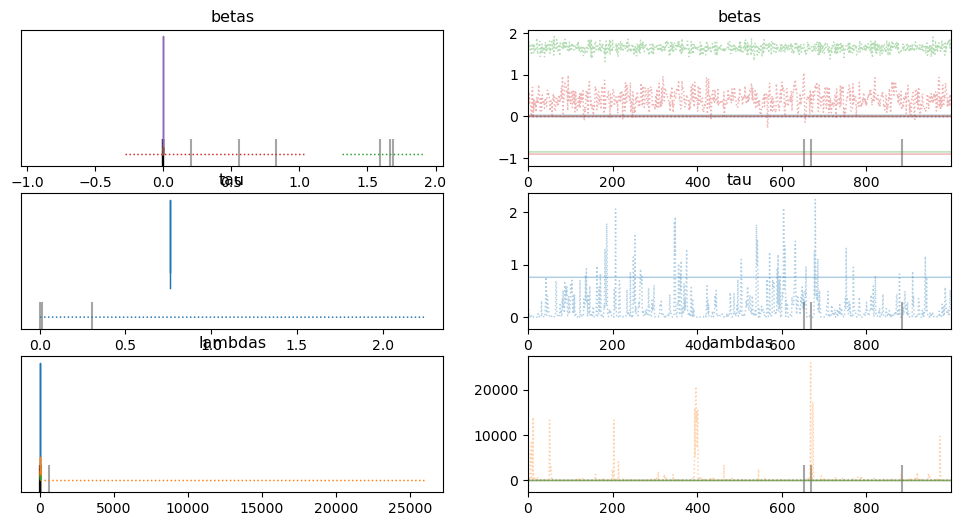

In [2]:
# -----------------------------------------------------------
# 2. Define and Fit the Model with Horseshoe Priors
# -----------------------------------------------------------
with pm.Model() as multivariate_model:
    # 1) LKJ Cholesky prior for covariance among outcome dimensions
    packed_L = pm.LKJCholeskyCov(
        "packed_L",
        n=m,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0, shape=m),
        compute_corr=False
    )
    L = pm.expand_packed_triangular(m, packed_L)

    # 2) Horseshoe prior for regression coefficients
    #    Global scale parameter tau ~ HalfCauchy
    tau = pm.HalfCauchy("tau", beta=1.0)

    #    Local scale parameters lambdas_j ~ HalfCauchy
    lambdas = pm.HalfCauchy("lambdas", beta=1.0, shape=p)

    #    The actual prior standard deviation for each beta_{j,k}
    #    We broadcast tau*lambdas_j to each outcome dimension k
    beta_sigma = tau * lambdas[:, None]  # shape = (p, m)

    #    Finally, betas_{j,k} ~ Normal(0, sigma = tau * lambdas_j)
    betas = pm.Normal("betas", mu=0, sigma=beta_sigma, shape=(p, m))

    # 3) Mean structure
    mu = pm.math.dot(X_data, betas)

    # 4) Multivariate normal likelihood
    y_obs = pm.MvNormal("y_obs", mu=mu, chol=L, observed=y_data)

    # 5) Sample from the posterior
    idata_hs = pm.sample(chains=2, random_seed=42)

# -----------------------------------------------------------
# 3. Summaries and Trace Plots
# -----------------------------------------------------------
summary_betas = az.summary(idata_hs, var_names=["betas", "tau", "lambdas"])
print(summary_betas)

az.plot_trace(idata_hs, var_names=["betas", "tau", "lambdas"])